# Matplotlib and pylab inline

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import libraries

In [2]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

from matplotlib import rcParams
from modules.reading import *
from modules.standardization import standardize_image
from modules.preprocessing import preproc_image
from modules.mask_and_contour import get_mask
from modules.noise import get_gradient, avg_grad, norm_vector
from pandas import DataFrame
from itertools import combinations as comb

rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = (4, 5)
rcParams["image.cmap"] = "gray"

## Read image

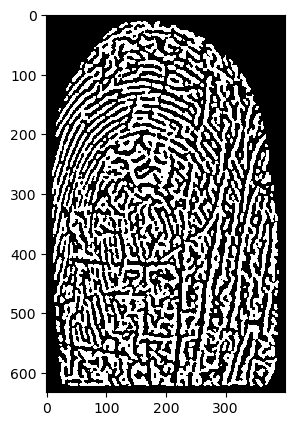

In [3]:
im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
std_im = standardize_image(im)
prep_im = preproc_image(std_im)


plt.imshow(prep_im)
plt.show()

# Get ready function of getting paired gradient

In [4]:
def get_pair_scalar_product_distribution(im, ksize=(17, 57)):
    
    dx, dy = get_gradient(im)
    
    dx_avg1, dy_avg1 = avg_grad(dx, dy, ksize[0])
    dx_avg2, dy_avg2 = avg_grad(dx, dy, ksize[1])
    
    mask0 = get_mask(im, with_ench=False) == 255
    mask1 = np.sqrt(dx_avg1*dx_avg1 + dy_avg1*dy_avg1) >  0.5
    mask2 = np.sqrt(dx_avg2*dx_avg2 + dy_avg2*dy_avg2) >  0.5
    
    mask = mask0 & mask1 & mask2
    
    dx_avg1, dy_avg1 = norm_vector(dx_avg1, dy_avg1)
    dx_avg2, dy_avg2 = norm_vector(dx_avg2, dy_avg2)
    
    sp = dx_avg1[mask] * dx_avg2[mask] + dy_avg1[mask] * dy_avg2[mask] 
    
    return sp

## Get get percentiles

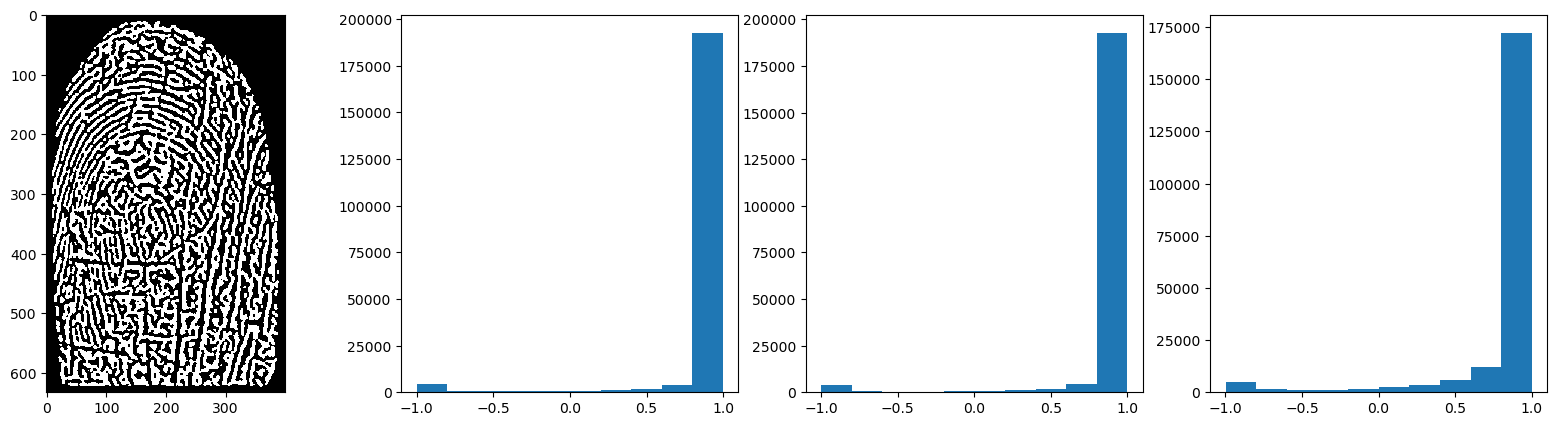

In [5]:
sp_17_33 = get_pair_scalar_product_distribution(prep_im, ksize=(17, 33))
sp_33_65 = get_pair_scalar_product_distribution(prep_im, ksize=(33, 65))
sp_17_65 = get_pair_scalar_product_distribution(prep_im, ksize=(17, 65))


fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))

ax0.imshow(prep_im, plt.cm.gray)
ax1.hist(sp_17_33.ravel())
ax2.hist(sp_33_65.ravel())
ax3.hist(sp_17_65.ravel())

plt.show()

## Perncentiles of pair scalar product

In [13]:
def get_pair_scalar_product_percentiles(im, ksize=(17, 65), ps=[5, 10, 20, 50]):
    pair_scalar_product = get_pair_scalar_product_distribution(im, ksize=ksize)
    percentiles = np.percentile(pair_scalar_product, ps)
    
    return percentiles

In [14]:
sp1 = get_pair_scalar_product_percentiles(prep_im, ksize=(17, 33))
sp2 = get_pair_scalar_product_percentiles(prep_im, ksize=(17, 65))
sp3 = get_pair_scalar_product_percentiles(prep_im, ksize=(33, 65))

sps = np.append([sp1, sp2], sp3)

sps

array([ 0.62914332,  0.90304538,  0.970889  ,  0.99625756, -0.01865574,
        0.558352  ,  0.85586906,  0.98522426,  0.66641831,  0.89675736,
        0.96960858,  0.99651692])

## Function for getting all percentiles

In [20]:
def get_all_pair_sp_percentiles(im, ksizes=(17, 33, 65), ps=[5, 10, 20, 50]):
    sp = np.array([])
    for ksize in comb(ksizes,  2):
        sp_ = get_pair_scalar_product_percentiles(im, ksize=ksize)
        sp = np.append(sp, sp_)
        
    return sp

In [21]:
sps = get_all_pair_sp_percentiles(prep_im)
sps

array([ 0.62914332,  0.90304538,  0.970889  ,  0.99625756, -0.01865574,
        0.558352  ,  0.85586906,  0.98522426,  0.66641831,  0.89675736,
        0.96960858,  0.99651692])

# Use Linear SVC for image classification

## Function for getting data

In [28]:
def get_xy_ims(filepath, images, x, y, y_val=1):
    
    for name in os.listdir(filepath):
        path = filepath + name
        im = cv.imread(path, cv.IMREAD_GRAYSCALE)
        
        if path == None:
            continue
        
        std_im = standardize_image(im)
        prep_im = preproc_image(std_im)
        percentiles = get_all_pair_sp_percentiles(prep_im)

        images.append(prep_im)
        x.append(percentiles)
        y.append(y_val)
    

## Get data

In [29]:
images, x, y = [], [], []


get_xy_ims(RAW_FILE_PATH_GOODIM, images, x, y)
get_xy_ims(RAW_FILE_PATH_BADIM_NOISE, images, x, y, y_val=0)

images = np.array(images)
x = np.array(x)
y = np.array(y)

DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.290100,0.947256,0.988582,0.998982,-0.890942,0.659377,0.947106,0.996443,0.823344,0.962376,0.991316,0.999159
1,0.927858,0.979914,0.994746,0.999305,0.704797,0.937609,0.985313,0.998208,0.972589,0.991475,0.997369,0.999641
2,0.766618,0.969722,0.992937,0.999327,-0.839274,0.809345,0.970951,0.997856,0.890377,0.975081,0.994671,0.999503
3,0.909012,0.974672,0.993657,0.999357,0.599616,0.897232,0.977809,0.998130,0.938364,0.980495,0.995278,0.999564
4,-0.090539,0.916672,0.981428,0.998088,-0.869876,0.191397,0.909839,0.993420,-0.041603,0.928463,0.985271,0.998560
...,...,...,...,...,...,...,...,...,...,...,...,...
90,-0.446046,0.759218,0.941917,0.991803,-0.831740,-0.203809,0.621999,0.951371,-0.737936,0.591934,0.905430,0.986317
91,0.782028,0.929211,0.976311,0.997017,0.357779,0.733863,0.908088,0.989029,0.869051,0.947631,0.980684,0.997429
92,-0.658016,0.821217,0.959176,0.995248,-0.898744,-0.140835,0.773457,0.980935,-0.628954,0.820312,0.958837,0.995916
93,-0.889946,0.683993,0.942610,0.992549,-0.934016,-0.659111,0.538354,0.958491,-0.932006,0.414345,0.914612,0.989076


## Train LinearSVC and get

Является хорошим, считается плохим [-0.92179408  0.84184671  0.97269479  0.9974507  -0.97091785 -0.68126974
  0.79063265  0.98905025 -0.9268743   0.811252    0.96903562  0.99755591]


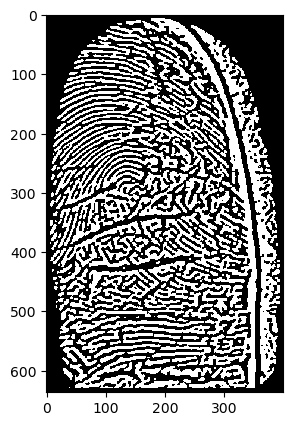

Является плохим, считается хорошим [0.57241488 0.88720143 0.96557344 0.99531914 0.02251788 0.55076021
 0.84419052 0.98067627 0.68639353 0.89419796 0.96452595 0.99535371]


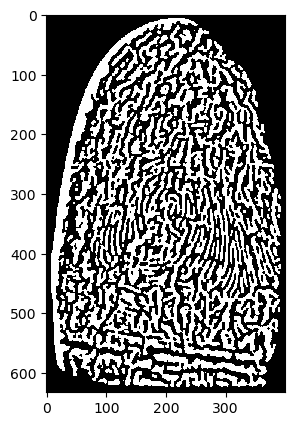

Является плохим, считается хорошим [ 0.60825987  0.89857731  0.96999994  0.99627024 -0.08677237  0.52596066
  0.85882433  0.98567977  0.63764586  0.89693652  0.97272256  0.99658659]


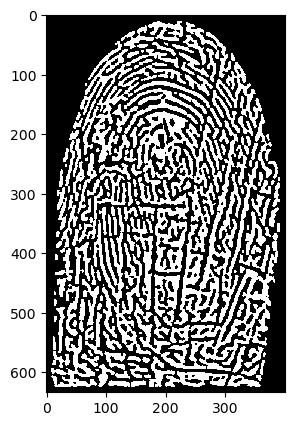

Является плохим, считается хорошим [ 0.62797914  0.90915487  0.97237415  0.99624743 -0.03262412  0.58865994
  0.87313285  0.98541229  0.70140011  0.91356327  0.97338989  0.99653543]


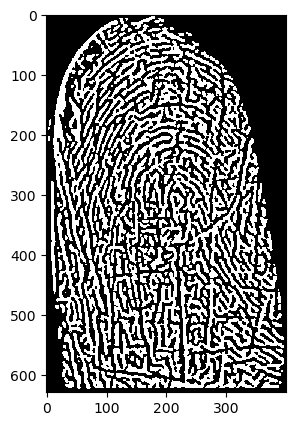

Является плохим, считается хорошим [0.74149483 0.92481863 0.97635877 0.99677216 0.30757553 0.71727937
 0.91434988 0.98918931 0.85838636 0.9516021  0.98421245 0.99762445]


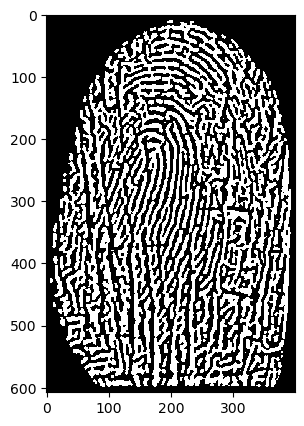

Является плохим, считается хорошим [ 0.62914332  0.90304538  0.970889    0.99625756 -0.01865574  0.558352
  0.85586906  0.98522426  0.66641831  0.89675736  0.96960858  0.99651692]


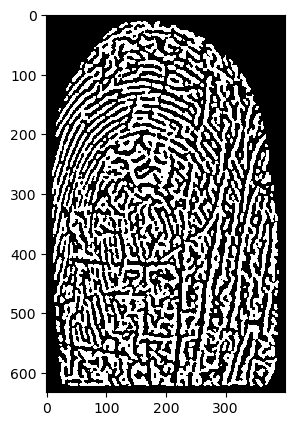

Является плохим, считается хорошим [0.78202768 0.92921077 0.97631143 0.99701699 0.35777941 0.73386261
 0.90808809 0.98902903 0.86905104 0.94763095 0.98068432 0.9974291 ]


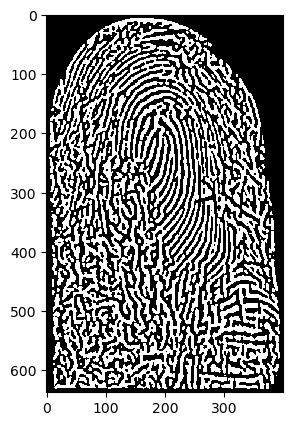

In [30]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

svc = LinearSVC(max_iter=1000000)
svc.fit(x, y)

predict = svc.predict(x)
bool_predict = predict != y


for im, good, percs in zip(images[bool_predict], y[bool_predict], x[bool_predict]):
    
    if good:
        print("Является хорошим, считается плохим", percs)
    else:
        print("Является плохим, считается хорошим", percs)
    
    plt.imshow(im, cmap=plt.cm.gray)
    plt.show()

In [31]:
x = DataFrame(x)
x.corr(method='spearman')

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,0.915844,0.873304,0.836643,0.844608,0.982866,0.905821,0.862441,0.968014,0.908033,0.873640,0.866039
1,0.915844,1.000000,0.988298,0.961183,0.655102,0.944386,0.992413,0.971962,0.920827,0.982684,0.977519,0.970100
2,0.873304,0.988298,1.000000,0.984308,0.573773,0.912484,0.991041,0.988256,0.886210,0.977029,0.987598,0.984686
3,0.836643,0.961183,0.984308,1.000000,0.509424,0.882528,0.971108,0.994289,0.855190,0.953862,0.976329,0.987570
4,0.844608,0.655102,0.573773,0.509424,1.000000,0.805189,0.639102,0.549249,0.816975,0.660001,0.586330,0.565654
5,0.982866,0.944386,0.912484,0.882528,0.805189,1.000000,0.944470,0.904351,0.991153,0.950573,0.920561,0.909139
6,0.905821,0.992413,0.991041,0.971108,0.639102,0.944470,1.000000,0.982236,0.926342,0.993883,0.990761,0.981551
7,0.862441,0.971962,0.988256,0.994289,0.549249,0.904351,0.982236,1.000000,0.880471,0.968448,0.986282,0.996766
8,0.968014,0.920827,0.886210,0.855190,0.816975,0.991153,0.926342,0.880471,1.000000,0.939374,0.902448,0.887316
9,0.908033,0.982684,0.977029,0.953862,0.660001,0.950573,0.993883,0.968448,0.939374,1.000000,0.987472,0.971052
